# Connecting existing clusters of a bicycle network
## Project: Bicycle network analysis with Gourab, Sayat, Tyler, Michael, Roberta

This notebook takes a city's existing bicycle network, then connects the biggest clusters following greedy triangulation. Code adapted from Tyler.

Contact: Michael Szell (michael.szell@gmail.com)  
Created: 2020-06-29  
Last modified: 2020-07-02

## Preliminaries

### Imports and magics

In [203]:
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import osmnx as ox
import copy
import math

%matplotlib inline
import pandas as pd
from matplotlib import cm

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [204]:
%watermark -n -v -m -g -iv

numpy     1.18.4
pandas    1.0.3
watermark 2.0.2
osmnx     0.13.0
igraph    0.8.2
Thu Jul 02 2020 

CPython 3.8.2
IPython 7.14.0

compiler   : Clang 9.0.1 
system     : Darwin
release    : 19.5.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit
Git hash   :


### Parameters

In [205]:
placeid = "budapest"

datapath = "../data/"
outpath = "../output/"
ymirrored = False

### Functions

In [206]:
# Graph plotting preparation functions
def my_plot_reset(G, nids = False):
    reset_plot_attributes(G)
    color_nodes(G, "red", nids)
    size_nodes(G, 8, nids)

def reset_plot_attributes(G):
    """Resets node attributes for plotting.
    All black and size 0.
    """
    G.vs["color"] = "black"
    G.vs["size"] = 0
        
def color_nodes(G, color = "blue", nids = False, use_id = True):
    """Sets the color attribute of a set of nodes nids.
    """
    if nids is False:
        nids = [v.index for v in G.vs]
        use_id = False
    if use_id:
        for nid in set(nids):
            G.vs.find(id = nid)["color"] = color
    else:
        G.vs[nids]["color"] = color

def size_nodes(G, size = 5, nids = False, use_id = True):
    """Sets the size attribute of a set of nodes nids.
    """
    if nids is False:
        nids = [v.index for v in G.vs]
        use_id = False
    if use_id:
        for nid in set(nids):
            G.vs.find(id = nid)["size"] = size
    else:
        G.vs[nids]["size"] = size

def color_edges(G, color = "blue", eids = False):
    """Sets the color attribute of a set of edge nids.
    """
    if eids is False:
        G.es["color"] = color
    else:
        G.es[eids]["color"] = color
        
def width_edges(G, width = 1, eids = False):
    """Sets the width attribute of a set of edge nids.
    """
    if eids is False:
        G.es["width"] = width
    else:
        G.es[eids]["width"] = width
        
# Other functions   
def round_coordinates(G, r = 7):
    for v in G.vs:
        G.vs[v.index]["x"] = round(G.vs[v.index]["x"], r)
        G.vs[v.index]["y"] = round(G.vs[v.index]["y"], r)

def mirror_y(G):
    for v in G.vs:
        y = G.vs[v.index]["y"]
        G.vs[v.index]["y"] = -y
    
def dist(v1,v2):
    dist = distance.euclidean((v1['x'],v1['y']),(v2['x'],v2['y']))
    return dist


def graph_from_plc(graph):
    """This function takes a open street map object 
    and returns an igraph network with edges weighted 
    with distance between nodes
    """
    nodes, edges = ox.graph_to_gdfs(graph)
    g = ig.Graph(directed=False)
    x = nodes['x'].tolist()
    y= nodes['y'].tolist()
    ids = nodes['osmid'].tolist()
    for i in range(len(x)):
        g.add_vertex(x=x[i],y=y[i],id=ids[i])
    df1 = pd.DataFrame(data=g.vs['id'],columns={'id'})
    df1['number'] = np.arange(0,len(list(g.vs())))
    edges1 = pd.merge(df1,edges,left_on='id',right_on='u')
    edges2 = pd.merge(df1,edges1,left_on='id',right_on='v')
    edgelist = (np.stack([edges2['number_x'].tolist(),edges2['number_y'].tolist()]).T).tolist()
    g.add_edges(edgelist)
    g.simplify()
    edge_list = g.get_edgelist()
    weights=[]
    for k in range(len(edge_list)):
        d = dist(g.vs()[edge_list[k][0]],g.vs()[edge_list[k][1]])
        weights.append(d)
    g.es()['weight'] = weights
    
    #bc = g.betweenness(weights='weight')
    return g


## Tyler's code from here

def osm_to_ig(node_imported,edge_imported):
    #node,edge = ox.graph_to_gdfs(G)
    node,edge = node_imported,edge_imported
    g = ig.Graph(directed=False)

    x_coords = node['x'].tolist() 
    y_coords = node['y'].tolist()
    ids = node['osmid'].tolist()
    coords=[]

    for i in range(len(x_coords)):
        g.add_vertex(x=x_coords[i],y=y_coords[i],id=ids[i])
        coords.append((x_coords[i],y_coords[i]))

    id_dict = dict(zip(g.vs['id'],np.arange(0,g.vcount()).tolist()))
    coords_dict = dict(zip(np.arange(0,g.vcount()).tolist(),coords))


    edge_list = []
    for i in range(len(edge)):
        edge_list.append([id_dict.get(edge['u'][i]),id_dict.get(edge['v'][i])])
        
    g.add_edges(edge_list)
    g.simplify()
    new_edges=g.get_edgelist()
    
    distances_list = []
    for i in range(len(new_edges)):
        distances_list.append(distance.euclidean(coords_dict.get(new_edges[i][0]),coords_dict.get(new_edges[i][1])))

    g.es()['weight']=distances_list
    return g   

## Exploratory Data Analysis

### Load networks

In [207]:
node_biketrack = pd.read_csv(datapath+placeid+'_biketrack_nodes.csv')
edge_biketrack = pd.read_csv(datapath+placeid+'_biketrack_edges.csv')
G_biketrack = osm_to_ig(node_biketrack, edge_biketrack)

node_bikeable = pd.read_csv(datapath+placeid+'_bikeable_nodes.csv')
edge_bikeable = pd.read_csv(datapath+placeid+'_bikeable_edges.csv')
G_bikeable = osm_to_ig(node_bikeable, edge_bikeable)

node_carall = pd.read_csv(datapath+placeid+'_carall_nodes.csv')
edge_carall = pd.read_csv(datapath+placeid+'_carall_edges.csv')
G_carall = osm_to_ig(node_carall, edge_carall)

with open(datapath+placeid+'_poi_railwaystation_nnidscarall.csv') as f:
    nnids = [int(line.rstrip()) for line in f]

round_coordinates(G_biketrack)
round_coordinates(G_bikeable)
round_coordinates(G_carall)

/Users/misz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (12,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/misz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/misz/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [208]:
# This loop is only for plotting, executed once, to mirror all y values
if not ymirrored:
    mirror_y(G_biketrack)
    mirror_y(G_bikeable)
    mirror_y(G_carall)
    ymirrored = True

### Plot the starting point

In [ ]:
my_plot_reset(G_biketrack, [])
ig.plot(G_biketrack, outpath + placeid + '_biketrack.pdf')
ig.plot(G_biketrack, outpath + placeid + '_biketrack.png', bbox=(800, 800))
ig.plot(G_biketrack, bbox=(400, 300), keep_aspect_ratio = False)

In [ ]:
my_plot_reset(G_bikeable, [])
ig.plot(G_bikeable, outpath + placeid + '_bikeable.pdf')
ig.plot(G_bikeable, outpath + placeid + '_bikeable.png', bbox=(800, 800))
ig.plot(G_bikeable, bbox=(400, 300), keep_aspect_ratio = False)

### Cluster analysis

In [65]:
G = copy.deepcopy(G_biketrack) # G is the graph we are working with

In [90]:
clusters = []
cluster_sizes = []
index = []
for i in range(len(list(G.components()))):
    #if (G_agg.subgraph(list(G_agg.components())[i]).vcount() > 200) :
    if len(list(G.components())[i]) > 200:
        index.append(i)
        cluster_sizes.append(G.subgraph(list(G.components())[i]).vcount())
        clusters.append(G.subgraph(list(G.components())[i]))
cluster_indices = sorted(range(len(cluster_sizes)),key=lambda k: cluster_sizes[k],reverse=True)

In [176]:
num_clusters = len(clusters)
num_clusters
cluster_indices

[2, 1, 4, 8, 9, 3, 5, 6, 0, 7]

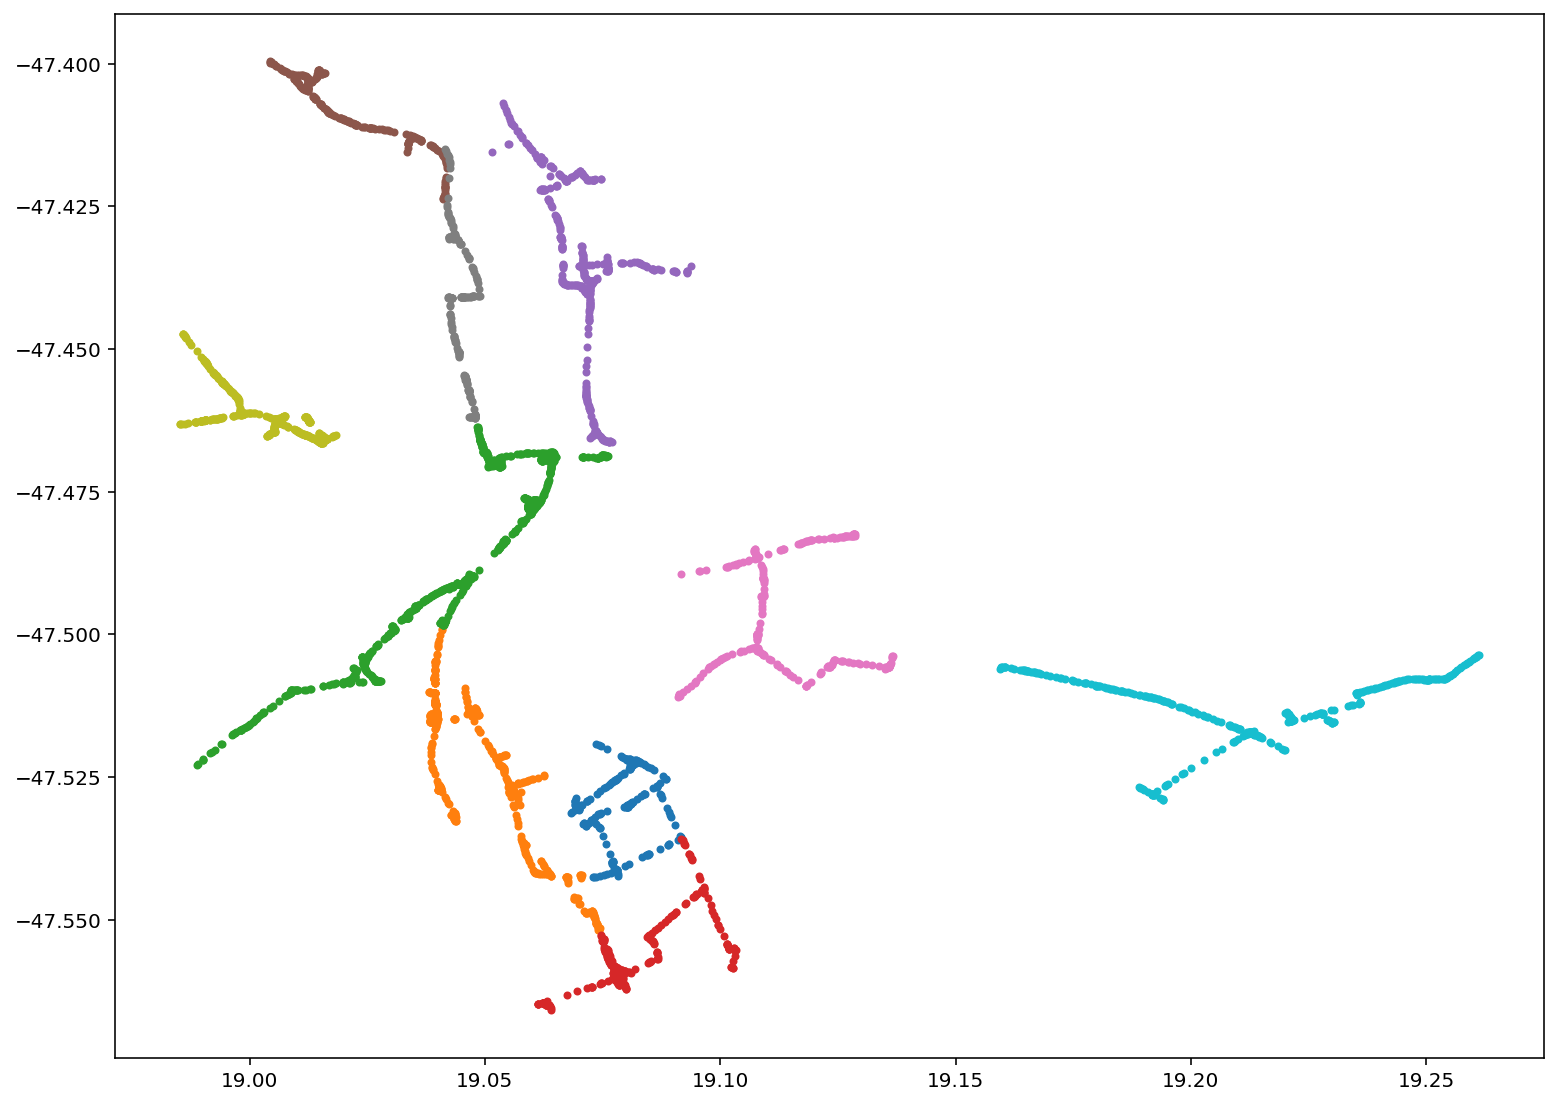

In [92]:
plt.figure(figsize=[2*6.4, 2*4.8])
for i in range(len(clusters)):
    plt.plot(clusters[i].vs['x'],clusters[i].vs['y'],'.')
%config InlineBackend.figure_format = 'retina'

#### Cluster functions

In [195]:
# Sayat closeness centrality calculator
def highest_closeness_node(G):
    closeness_values = G.closeness(weights = 'weight')
    sorted_closeness = sorted(closeness_values, reverse = True)
    index = closeness_values.index(sorted_closeness[i])
    return G.vs(index)['id']

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
def ccw(A,B,C):
    return (C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)

def segments_intersect(A,B,C,D):
    """Check if two line segments intersect (except for colinearity)
    Returns true if line segments AB and CD intersect properly.
    Adapted from: https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
    """
    if (A.x == C.x and A.y == C.y) or (A.x == D.x and A.y == D.y) or (B.x == C.x and B.y == C.y) or (B.x == D.x and B.y == D.y): return False # If the segments share an endpoint they do not intersect properly
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def new_edge_intersects(G, enew):
    """Given a graph G and a potential new edge enew,
    check if enew will intersect any old edge.
    """
    E1 = Point(enew[0], enew[1])
    E2 = Point(enew[2], enew[3])
    for e in G.es():
        O1 = Point(e.source_vertex["x"], e.source_vertex["y"])
        O2 = Point(e.target_vertex["x"], e.target_vertex["y"])
        if segments_intersect(E1, E2, O1, O2):
            return True
    return False
    
    
def greedy_triangulation(GT, poipairs, betweenness_quantile = 1):
    """Greedy Triangulation (GT) of a graph GT with an empty edge set.
    Distances between pairs of nodes are given by poipairs.
    
    The GT connects pairs of nodes in ascending order of their distance provided
    that no edge crossing is introduced. It leads to a maximal connected planar
    graph, while minimizing the total length of edges considered. 
    See: cardillo2006spp
    """
    
    for poipair, poipair_distance in poipairs:
        #print(poipair[0])
        #print(GT.vs['id'])
        poipair_ind = (GT.vs.find(id = poipair[0]).index, GT.vs.find(id = poipair[1]).index)
        if not new_edge_intersects(GT, (GT.vs[poipair_ind[0]]["x"], GT.vs[poipair_ind[0]]["y"], GT.vs[poipair_ind[1]]["x"], GT.vs[poipair_ind[1]]["y"])):
            GT.add_edge(poipair_ind[0], poipair_ind[1], weight = poipair_distance)
            
    # Get betweenness for prioritization
    BW = GT.edge_betweenness(False, None, "weight")
    qt = np.quantile(BW, 1-betweenness_quantile)
    sub_edges = []
    for c, e in enumerate(GT.es):
        if BW[c] >= qt: 
            sub_edges.append(c)
        GT.es[c]["bw"] = BW[c]
        GT.es[c]["width"] = math.sqrt(BW[c]+1)*0.5
    # Prune
    GT = GT.subgraph_edges(sub_edges)
    
    return GT
    

def greedy_triangulation_routing_clusters(G, clusters, cluster_indices, closest_list):
    """Greedy Triangulation (GT) of a graph G's clusters,
    then routing to connect the GT.
    G is an ipgraph graph
    
    The GT connects pairs of clusters in ascending order of their distance provided
    that no edge crossing is introduced. It leads to a maximal connected planar
    graph, while minimizing the total length of edges considered. 
    See: cardillo2006spp
    
    Distance here is routing distance, while edge crossing is checked on an abstract 
    level.
    """
    
    # GT is the Graph with the routing of the greedy triangulation
    GT_indices = set()
    # GT_abstract is the graph with same nodes but euclidian links to keep track of edge crossings
    clusterinfo = {}
    centroid_indices = []
    centroidid_is_cluster = {}
    for c in cluster_indices:
        clusterinfo[c] = {}
        clusterinfo[c]['centroid_id'] = highest_closeness_node(clusters[c])[0]
        clusterinfo[c]['centroid_index'] = G.vs.find(id = clusterinfo[c]['centroid_id']).index
        centroid_indices.append(clusterinfo[c]['centroid_index'])
        centroidid_is_cluster[clusterinfo[c]['centroid_id']] = c
        
    G_temp = copy.deepcopy(G)
    for e in G_temp.es: # delete all edges
        G_temp.es.delete(e)
    GT_abstract = G_temp.subgraph(centroid_indices)
    
    clusterpairs = clusterpairs_by_distance(G, clusters, cluster_indices, True)
    centroidpairs = [((clusterinfo[c[0][0]]['centroid_id'], clusterinfo[c[0][1]]['centroid_id']), c[2]) for c in clusterpairs]
    
    GT_abstract = greedy_triangulation(GT_abstract, centroidpairs)
    
#     # Get node pairs we need to route, sorted by distance
#     routenodepairs = []
#     for e in GT_abstract.es:
#         sourcenodeid = 
#         routenodepairs.append()
        
#         routenodepairs[(e.source_vertex["id"], e.target_vertex["id"])] = e["weight"]
#     routenodepairs = sorted(routenodepairs.items(), key = lambda x: x[1])
    
#     # Do the routing
#     for poipair, poipair_distance in routenodepairs:
#         poipair_ind = (G.vs.find(id = poipair[0]).index, G.vs.find(id = poipair[1]).index)
#         sp = set(G.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
#         GT_indices = GT_indices.union(sp)

#     GT = G.induced_subgraph(GT_indices)
    
#     return (GT, GT_abstract)
    return(GT_abstract)


def clusterpairs_by_distance(G, clusters, cluster_indices, return_distances = False):
    """Calculates the (weighted) graph distances on G for a number of clusters.
    Returns all pairs of cluster ids and closest nodes in ascending order of their distance. 
    If return_distances, then distances are also returned.

    Returns a list containing these elements, sorted by distance:
    [(clusterid1, clusterid2), (closestnodeid1, closestnodeid2), distance]
    """
    
    closest_dict = {}
    clustercopies = {}
    
    # Create copies of all clusters
    for c1 in cluster_indices:
        clustercopies[c1] = clusters[cluster_indices[c1]].copy()
        
    # Take one cluster
    for i, c1 in enumerate(cluster_indices):
        # Go through all other clusters
        print(i)
        for j, c2 in enumerate(cluster_indices[i+1:]):
            closest_pair = {'i': 0, 'j': 0}
            min_dist = np.inf
            for a in list(clustercopies[c1].vs()):
                for b in list(clustercopies[c2].vs()):
                    dist_nodes = dist(a,b) # To do: Change this to shortest path distance
                    if dist_nodes < min_dist:
                        closest_pair['i'] = a['id']
                        closest_pair['j'] = b['id']
                        min_dist = dist_nodes
            closest_list.append([(c1,c2), (closest_pair['i'],closest_pair['j']), min_dist])
            
    closest_list.sort(key = lambda x: x[-1])
    if return_distances:
        return closest_list
    else:
        return [[o[0], o[1]] for o in closest_list]

In [196]:
# Get the pairs of distances between all clusters, where distance is routing distance of the closest nodes
closest_list = clusterpairs_by_distance(G_agg, clusters, cluster_indices, True)
closest_list

0
1
2
3
4
5
6
7
8
9


[[(2, 1), (35523879, 35523879), 0.0],
 [(1, 8), (272878389, 272878389), 0.0],
 [(4, 3), (84685564, 84685564), 0.0],
 [(8, 6), (215402640, 215402640), 0.0],
 [(9, 7), (372456661, 372456661), 0.0],
 [(2, 1), (35523879, 35523879), 0.0],
 [(1, 8), (272878389, 272878389), 0.0],
 [(4, 3), (84685564, 84685564), 0.0],
 [(8, 6), (215402640, 215402640), 0.0],
 [(9, 7), (372456661, 372456661), 0.0],
 [(8, 5), (1285886896, 509441359), 0.00020687759665792598],
 [(9, 6), (4054231664, 1216812188), 0.000663264962139663],
 [(1, 0), (288825239, 5219690926), 0.0008008277030640374],
 [(1, 5), (1903052361, 294696996), 0.0009253445304333938],
 [(9, 0), (3325126119, 3325126123), 0.0016466650539787764],
 [(2, 0), (735742808, 685059031), 0.0024365206750623135],
 [(1, 8), (1387110237, 2765803357), 0.0024555843622240652],
 [(2, 9), (6096044395, 6217608415), 0.009117713792942152],
 [(2, 6), (6096044395, 680056384), 0.009807709222854285],
 [(8, 5), (1285886896, 509441359), 0.013228213533959397],
 [(8, 5), (1285886

In [191]:
GT_abstract = greedy_triangulation_routing_clusters(G_agg, clusters, cluster_indices, closest_list)

0
1
2
3
4
5
6
7
8
9


InternalError: Error at /Users/runner/miniforge3/conda-bld/python-igraph_1588168241529/work/vendor/source/igraph/src/centrality.c:2109: Weight vector must be positive, Invalid value

igraph.Vertex(<igraph.Graph object at 0x7fec6eeb2220>, 0, {'x': 19.0725686, 'y': -47.532712, 'id': 727785417, 'color': 'black', 'size': 0})


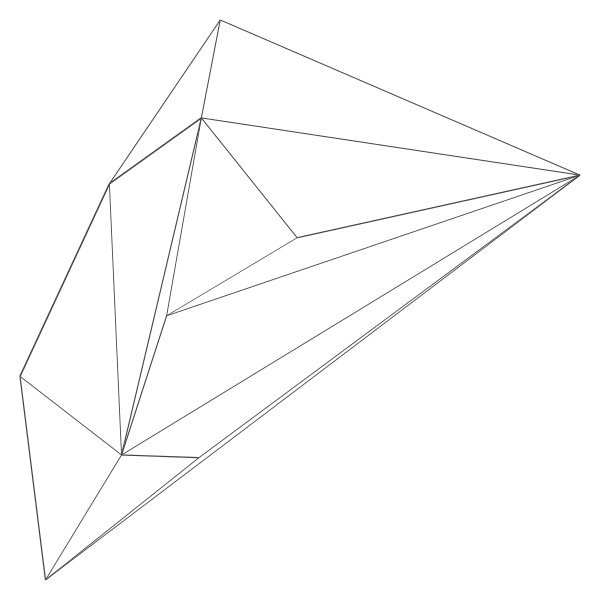

In [185]:
print(GT_abstract.vs[0])
ig.plot(GT_abstract)

In [25]:
#more sayat code + additions
G_only_cl_5 = clusters[cluster_indices[0]].copy()
for i in range(1,len(clusters)):
    #closest nodes
    sh_pt = g_biggest.get_all_shortest_paths(id_dict.get(closest_list[i-1][0]) ,id_dict.get(closest_list[i-1][1]) ,weights='weight')[0]
    
    #highest closeness centrality
    #sh_pt1 = g_biggest.get_all_shortest_paths(id_dict.get(closeness(G_only_cl_5,0)[0]) ,id_dict.get(closeness(clusters[cluster_indices[i]],0)[0]) ,weights='weight')[0]
    
    #random nodes
    #sh_pt2 = g_biggest.get_all_shortest_paths(id_dict.get(np.random.choice(G_only_cl_5.vs())["id"]),id_dict.get(np.random.choice(clusters[cluster_indices[i]].vs())["id"]),weights='weight')[0]

    nw = np.unique(G_only_cl_5.vs()['id'] + clusters[cluster_indices[i]].vs()['id']
                  +  g_biggest.vs(sh_pt)['id']
                   #+   g_biggest.vs(sh_pt1)['id']
                   #+   g_biggest.vs(sh_pt2)['id']
                  )
    G_only_cl_5 = g_biggest.subgraph([id_dict.get(key) for key in nw])
    print(i,G_only_cl_5.vcount(),G_only_cl_5.ecount())

1 1932 2128
2 2660 2937
3 3572 3931
4 4674 5094
5 5344 5842
6 5982 6561
7 6629 7248
8 7817 8444
9 8566 9234
10 9061 9779
11 9741 10500
12 10359 11134
13 10724 11531
14 11130 11966
15 11532 12425
16 11903 12830
17 12495 13448
18 13057 14048
19 13319 14366
20 13666 14737
21 14005 15124
22 14297 15436
23 14605 15787
24 14895 16092
25 15247 16468
26 15475 16712
27 15708 16962
28 16200 17479
29 16476 17787
30 16690 18020
31 17039 18377


# Old code

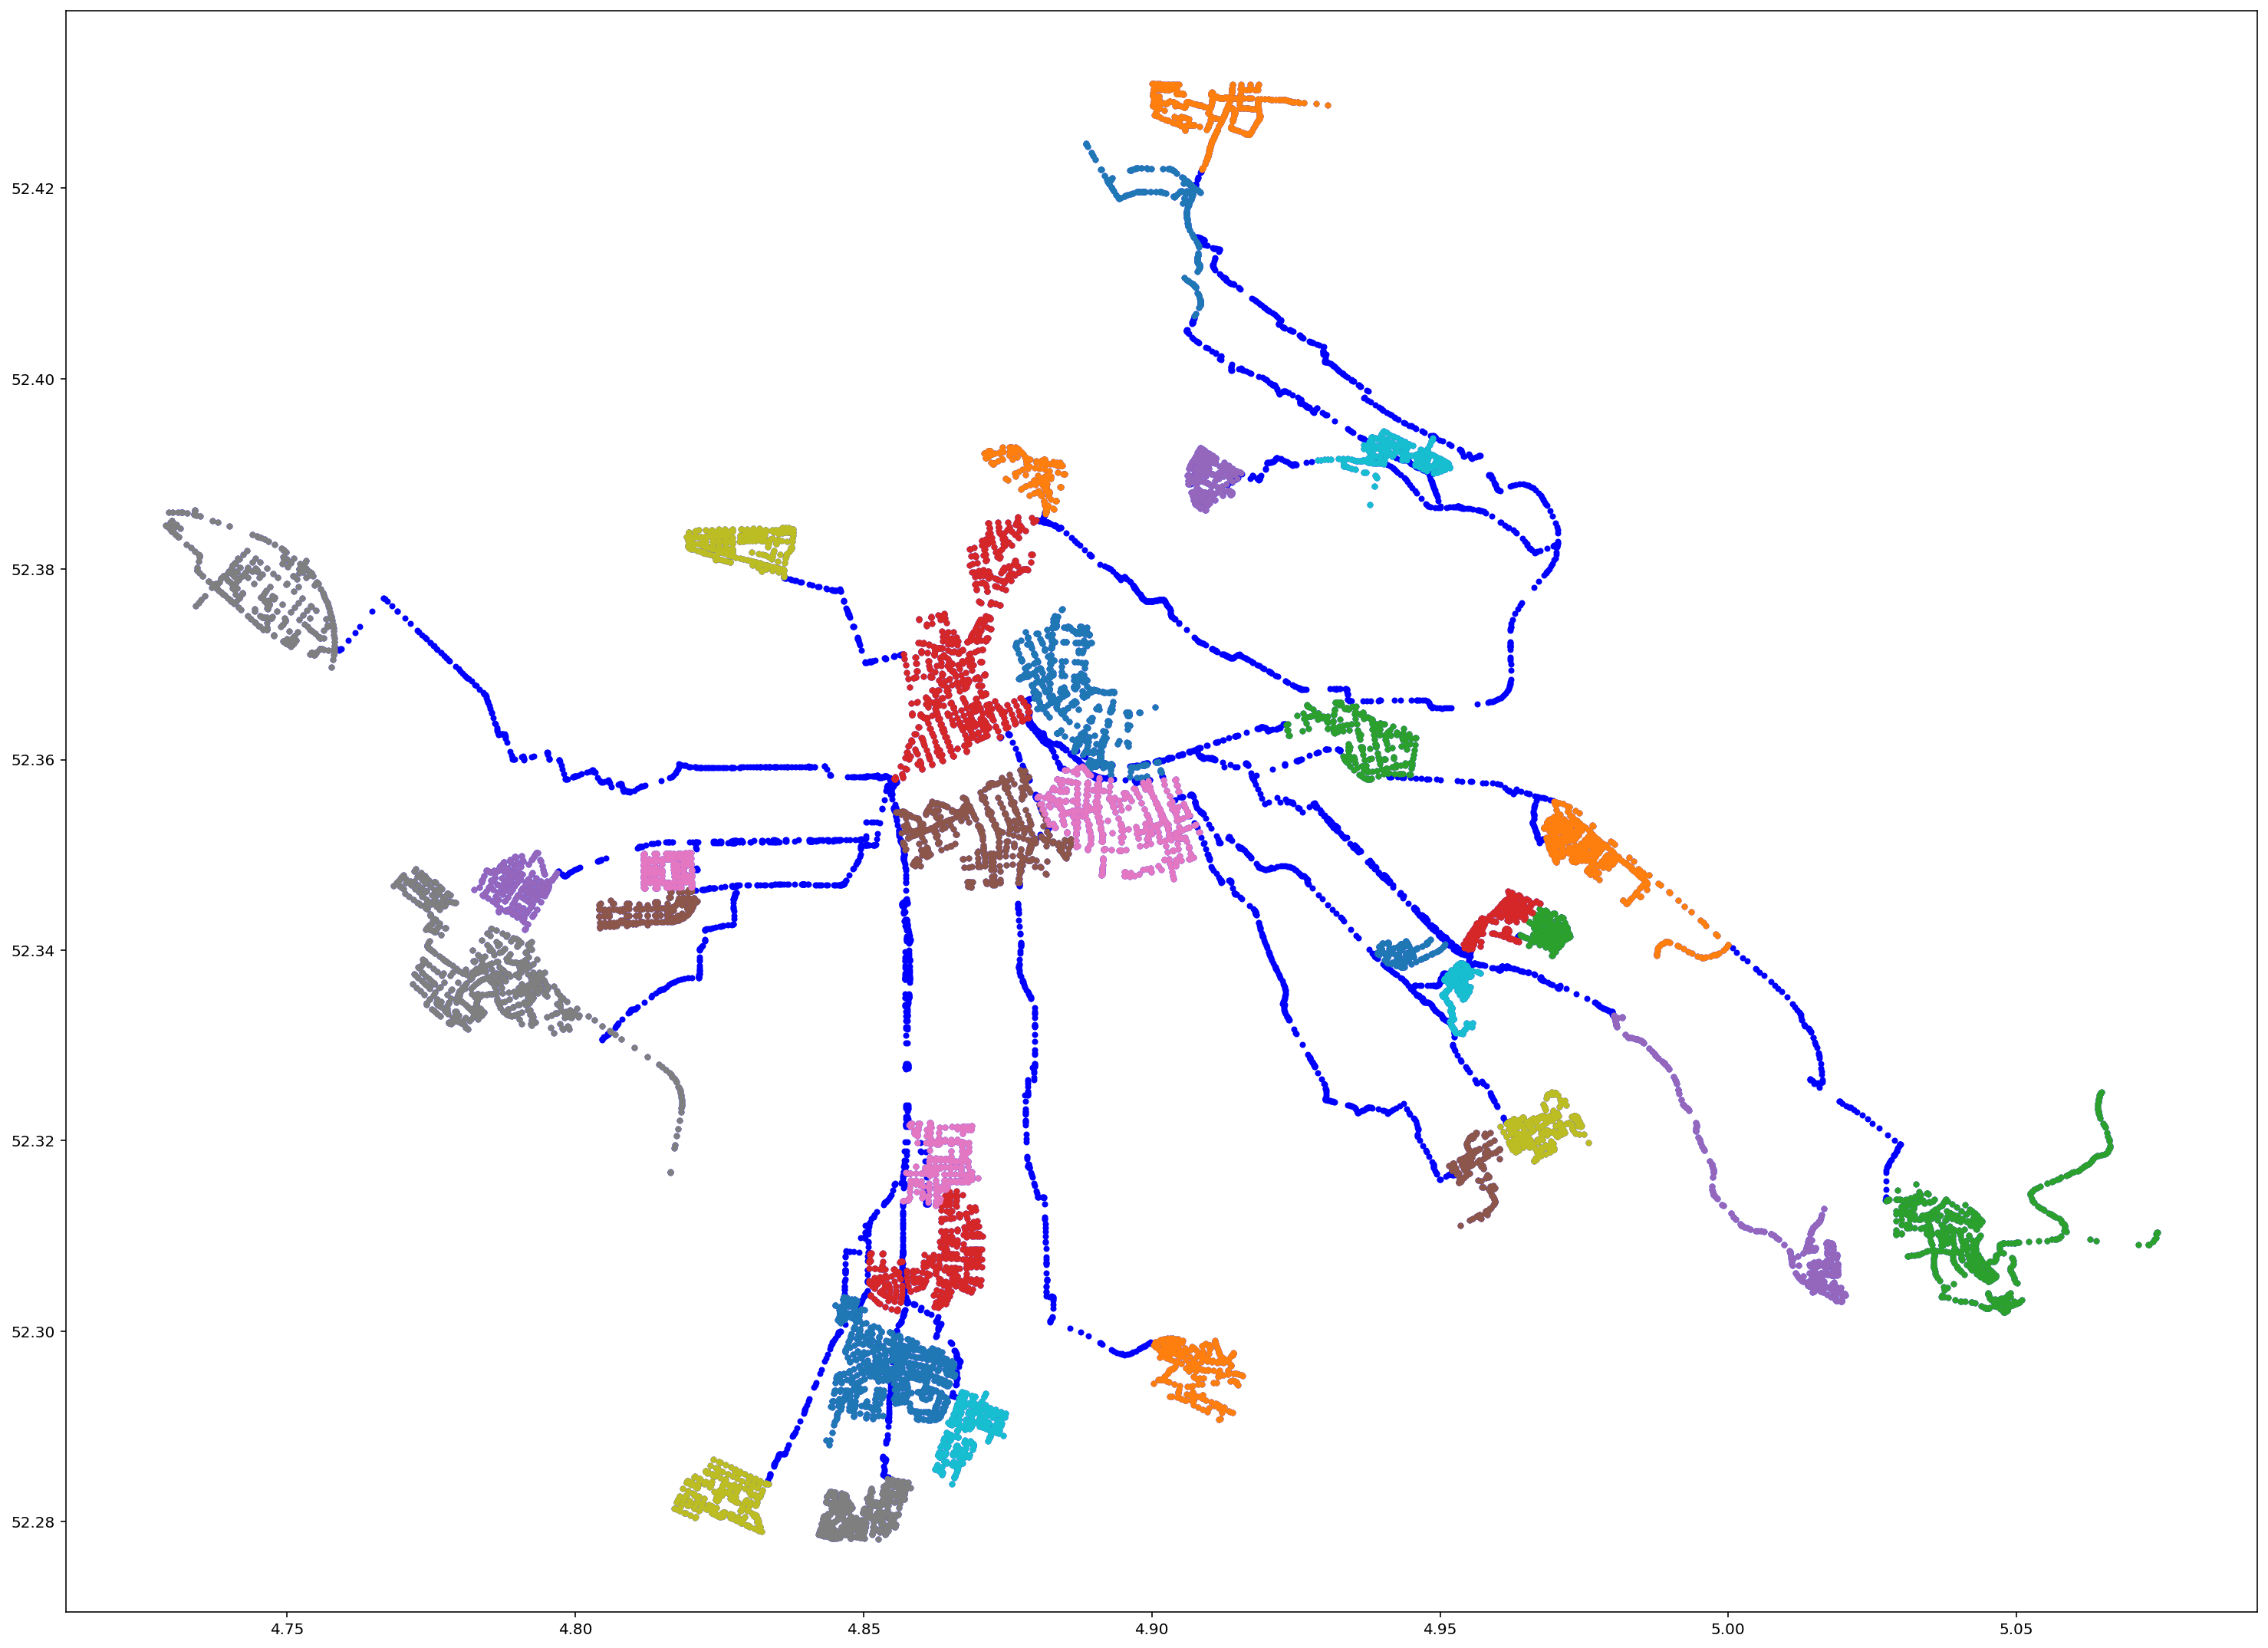

In [26]:
plt.figure(figsize=[4*6.4,4*4.8])
plt.plot(G_only_cl_5.vs['x'],G_only_cl_5.vs['y'],'.',color='blue')
for i in range(len(clusters)):
    plt.plot(clusters[i].vs['x'],clusters[i].vs['y'],'.')
%config InlineBackend.figure_format = 'retina'